# Evaluate Scaling Performance
Measure how well each application uses resources as we scale

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import interpolate
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import json
import sys
import re

params = {'legend.fontsize': 8,
         'axes.labelsize': 9,
         'axes.titlesize':'x-large',
         'xtick.labelsize': 6,
         'ytick.labelsize': 6}
plt.rcParams.update(params)

In [2]:
log_re = r"^(?P<date>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<module>\S+) - (?P<level>[A-Z]+) - (?P<message>[\s\S]*?)(?=^\d{4})"

## Load Runs
Get the data from the productive-level runs

In [3]:
runs = list(Path("prod-runs").glob("*"))

In [4]:
def get_run_data(path: Path):
    """Get the data about a run
    
    Args:
        path: Path to the run
    Returns:
        (dict) Data about the run
    """
    
    # Get the basic information
    output = dict(path=path, study=path.name.split("_")[-1])
    with open(path.joinpath('run_params.json')) as fp:
        run_params = json.load(fp)
    output['num_nodes'] = run_params['nnodes']
    for k in ['random', 'retrain_frequency', 'nodes_per_task']:
        output[k] = run_params.get(k)
    
    # Get the start-time
    with open(path.joinpath('runtime.log')) as fp:
        line = fp.readline().strip()
        start_time = datetime.strptime(line.split(" - ")[0].strip(), "%Y-%m-%d %H:%M:%S,%f")
    output['start_time'] = start_time
        
    return output

In [5]:
results = pd.DataFrame([get_run_data(x) for x in runs])

In [6]:
results

,path,study,num_nodes,random,retrain_frequency,nodes_per_task,start_time
0,prod-runs/256-nodes_update-8,update-8,256,None,8,4,2021-07-07 21:53:41.933
1,prod-runs/256-nodes_random,random,256,True,50,4,2021-03-28 06:02:32.191
2,prod-runs/128-nodes_random,random,128,True,50,4,2021-04-04 17:05:48.192
3,prod-runs/256-nodes_no-retrain,no-retrain,256,None,2000,4,2021-07-02 03:36:48.282


## Build tools for Assessing Utilization
Retrieve the amount of resources at each time and the resources allocated

In [7]:
def load_log(path: Path) -> pd.DataFrame:
    """Load the Colmena runtime log
    
    Args:
        path: Path to the run files
    Returns:
        DataFrame of the log messages
    """
    with open(path.joinpath('runtime.log')) as fp:
        log_data = pd.DataFrame([x.groupdict() for x in re.finditer(log_re, fp.read(), re.MULTILINE)])
    log_data['datetime'] = log_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S,%f').timestamp())
    return log_data

In [8]:
def get_resource_allocation(path: Path) -> pd.DataFrame:
    """Get the resource allocation over time for a run
    
    Args:
        path: Path to the run files
    Returns:
        Resource allocations at different times. Each row indicates
        when the allocation changed from one strategy to another
    """
    
    # Load in the runtime log
    log_data = load_log(path)
    start_time = log_data['datetime'].iloc[0]
    end_time = log_data['datetime'].iloc[-1]
        
    # Get the resource messages
    log_data.query('module=="colmena.thinker.resources"', inplace=True)
    
    # Record allocation changes
    rec_re = re.compile(r'Transferred (?P<count>\d+) slots from (?P<from>\w+) to (?P<to>\w+)')
    log_data['parsed'] = log_data['message'].apply(rec_re.match)
    log_data = log_data[[x is not None for x in log_data['parsed']]]
    resource_changes = pd.DataFrame(log_data['parsed'].apply(lambda x: x.groupdict()).tolist())
    resource_changes['datetime'] = log_data['datetime'].values
    
    # Convert count to an int
    resource_changes['count'] = resource_changes['count'].apply(int)
    
    # Infer the total number of slots
    #  Assume we assign all nodes from None to a pool
    total_counts = resource_changes[resource_changes['from'] == "None"]['count'].sum()
    
    # Write down the initial allocation (all in None)
    state = dict((x, 0) for x in ['inference', 'training', 'simulation', 'time'])
    state['None'] = total_counts
    
    # Measure how they change over time
    states = [state.copy()]
    for _, change in resource_changes.iterrows():
        # Record the new time
        state['time'] = change['datetime'] - start_time
        
        # Update the state
        state[change['to']] += change['count']
        state[change['from']] -= change['count']
        
        # Add to the history
        states.append(state.copy())
        
    # Add in a last time for the end
    state['time'] = end_time - start_time
    states.append(state)
    
    return pd.DataFrame(states)

In [9]:
def get_utilization(path: Path) -> pd.DataFrame:
    """Get the utilization of different resources as a function of time.
    
    We determine utilization as when a task is actually executing on a worker
    
    Args:
        path: Path to the run files
    Returns:
        Amount of slots used by each task as a function of time.
    """
    
    # Load the log
    log_data = load_log(path)
    start_time = log_data['datetime'].iloc[0]
    
    # Get the number of slots per QC task
    with open(path.joinpath('run_params.json')) as fp:
        run_params = json.load(fp)
        slots_per_qc = run_params['nodes_per_task']
    
    # Compile the run time for each completed tasks
    events = []
    for ttype, dpath in zip(['training', 'inference', 'simulation'], 
                           ['training-results.json', 'inference-records.json', 'simulation-results.json']):
        dpath = path.joinpath(dpath)
        if not dpath.is_file(): 
            continue
            
        # Process each result
        with open(dpath) as fp:
            for line in fp:
                data = json.loads(line)
                events.append({
                    'time': data['time_compute_started'] - start_time,
                    'type': ttype,
                    'change': slots_per_qc if ttype == 'simulation' else 1
                })  # Compute starting
                events.append({
                    'time': data['time_compute_started'] + data['time_running'] - start_time,
                    'type': ttype,
                    'change': -slots_per_qc if ttype == 'simulation' else -1
                })  # Compute finishing           
    events = pd.DataFrame(events)
    
    # Keep track of the total state
    state = dict((x, 0) for x in ['inference', 'training', 'simulation', 'time'])
    states = [state.copy()]
    for _, event in events.sort_values('time').iterrows():
        state['time'] = event['time']
        state[event['type']] += event['change']
        states.append(state.copy())
    
    return pd.DataFrame(states)

## Plot the Allocation and Utilization Over Time
See how well we do!

In [10]:
target_run = results.query('num_nodes==256 and retrain_frequency==8 and study=="update-8"').iloc[0]

In [11]:
allocation = get_resource_allocation(target_run['path'])

In [12]:
utilization = get_utilization(target_run['path'])

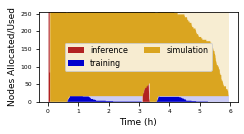

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 1.9))

order = ['inference', 'training', 'simulation']
color = ['firebrick', 'mediumblue', 'goldenrod']

# Plot the allocation and usage for the first type
ax.fill_between(allocation['time'] / 3600, allocation['inference'], step='post', alpha=0.2, color=color[0], edgecolor='none')
ax.fill_between(utilization['time'] / 3600, utilization['inference'], step='post', color=color[0], label=order[0], edgecolor='none')

# Plot the utilization for the remaining task types
for i in range(1, len(color)):
    start = allocation[order[:i]].sum(axis=1)
    ax.fill_between(allocation['time'] / 3600, allocation[order[i]] + start, y2=start, step='post', alpha=0.2, color=color[i], edgecolor='none')
    
    # Determine the start point for the utilization
    start = interpolate.interp1d(allocation['time'], start, kind='previous', fill_value='extrapolate')(utilization['time'])
    ax.fill_between(utilization['time'] / 3600, utilization[order[i]] + start, y2=start, step='post', color=color[i], label=order[i], edgecolor='none')

ax.set_ylim(0, max(allocation[order].sum(axis=1)))
ax.legend(loc='center', ncol=2)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Nodes Allocated/Used')

fig.tight_layout()
fig.savefig('figures/utilization-over-time.pdf')
fig.savefig('figures/utilization-over-time.png', dpi=320)

Compute the amount dedicated to each task

In [14]:
def compute_hours_allocated(path: Path):
    """Compute the hours allocated to each task"""
    
    # Compute the allocation
    allocation = get_resource_allocation(path)
    
    # Get the amount of time for each stage
    time_incr = allocation['time'].diff()[1:].values
    
    # For each task, compute the total run time
    return dict(
        (t, np.dot(allocation[t].values[:-1], time_incr) / 3600) for t in ['training', 'inference', 'simulation']
    )
    

In [15]:
def compute_hours_used(path: Path):
    """Compute the hours used for each task"""
    
    # Compute the allocation
    allocation = get_utilization(path)
    
    # Get the amount of time for each stage
    time_incr = allocation['time'].diff()[1:].values
    
    # For each task, compute the total run time
    return dict(
        (t, np.dot(allocation[t].values[:-1], time_incr) / 3600) for t in ['training', 'inference', 'simulation']
    )
    

In [16]:
total_allocated = compute_hours_allocated(target_run['path'])
total_allocated

{'training': 76.50876111110051,
 'inference': 30.07434888548321,
 'simulation': 1415.7855300045014}

In [17]:
total_used = compute_hours_used(target_run['path'])

In [18]:
print(f'Utilization: {sum(total_used.values())/sum(total_allocated.values())*100:.1f}%')

Utilization: 86.3%


Repeat for the "non-retrain" run

In [19]:
compute_hours_allocated(results.query('num_nodes==256 and retrain_frequency>=1000')['path'].iloc[0])

{'training': 0.0,
 'inference': 34.366008894178606,
 'simulation': 1480.845653330485}

## Estimate Latency of Creating Simulations
We want to measure the difference in time between when a simulation completing and the next being launched. We will do by getting statistics of the three operations:
1. Time to send results from worker to Thinker
1. Time for thinker to submit the next task
1. Time for task to launch on a worker

In [20]:
def assess_result_transfer_overhead(path: Path) -> np.ndarray:
    """Assess the time it takes a result to move from worker to thinker
    
    Args:
        path: Path to the run files
    Returns:
        List of the observed latencies
    """
    
    # Get the path to the simulation results
    res_path = path / "simulation-results.json"
    latencies = []
    with open(res_path) as fp:
        for line in fp:
            data = json.loads(line)
            latencies.append(
                data["time_serialize_results"] + data["time_deserialize_results"] +
                data["time_result_received"] - (data["time_compute_started"] + data["time_running"])
            )
    return np.array(latencies)

In [21]:
def assess_request_transfer_overhead(path: Path) -> np.ndarray:
    """Assess the time it takes for a task to move from Thinker to worker"""
    
    # Get the path to the simulation results
    res_path = path / "simulation-results.json"
    latencies = []
    with open(res_path) as fp:
        for line in fp:
            data = json.loads(line)
            latencies.append(
                data["time_compute_started"] - data["time_created"]
            )
    return np.array(latencies)

In [22]:
def assess_response_time(path: Path) -> np.ndarray:
    """Measure the time it takes for the Thinker to generate a new molecule"""
    
    # Load the logs
    log_data = load_log(path)
    
    # Get the time the jobs where received
    result_received = log_data[log_data.message.str.startswith('Client received a run_simulation')]
    
    # Get the actions taken after receiving a result
    request_sent = log_data[np.logical_or(log_data.message.str.startswith('Client sent a run_simulation'),
                                          log_data.message.str.startswith('Transferred 4 slots from simulation'))]
    
    # Remove tasks that have not yet been responded to
    result_received = result_received[result_received.datetime < request_sent.datetime.max()]
    
    # Determine the time of the next action after a result was received
    next_action = interpolate.interp1d(request_sent.datetime, request_sent.datetime, kind='next')(result_received.datetime - 2e-3)
    
    return (next_action - result_received.datetime).values

In [23]:
def profile_response_times(path: Path) -> pd.DataFrame:
    """Profile the various latencies involved in responding to a simulation completeing
    
    Args:
        path: Path to the simulation files
    Returns:
        Assessment of the various aspects of latency
    """
    
    output = []
    for task, times in {
        'result_transfer': assess_result_transfer_overhead(path),
        'request_transfer': assess_request_transfer_overhead(path),
        'response_time': assess_response_time(path)
    }.items():
        output.append({
            'task': task,
            'count': len(times),
            'mean': np.mean(times),
            'median': np.median(times),
            '75th': np.percentile(times, 75),
            'max': np.max(times)
        })
    return pd.DataFrame(output)

In [24]:
profile_response_times(target_run['path'])

,task,count,mean,median,75th,max
0,result_transfer,354,0.858702,0.647106,1.232552,3.681340
1,request_transfer,354,0.192682,0.009932,0.045279,2.027974
2,response_time,354,0.072189,0.054000,0.081750,1.097000


## Estimate Latency of Creating Simulations
We want to measure the difference in time between when a simulation completing and the next being launched. We will do by getting statistics of the three operations:
1. Time to send results from worker to Thinker
1. Time for thinker to submit the next task
1. Time for task to launch on a worker

In [25]:
def assess_result_transfer_overhead(path: Path, records: str = 'simulation-results.json',
                                    successful: bool = None) -> np.ndarray:
    """Assess the time it takes a result to move from worker to thinker
    
    Args:
        path: Path to the run files
        records: Name of the record file
        successful: Whether to get only the successful, failed tasks or both
    Returns:
        List of the observed latencies
    """
    
    # Get the path to the simulation results
    res_path = path / records
    latencies = []
    with open(res_path) as fp:
        for line in fp:
            data = json.loads(line)
            
            # If desired, get only failed or successful tasks
            if successful is not None:
                if data['success'] != successful:
                    continue
                
            latencies.append(
                data["time_serialize_results"] + data["time_deserialize_results"] +
                data["time_result_received"] - (data["time_compute_started"] + data["time_running"])
            )
    return np.array(latencies)

In [26]:
def assess_request_transfer_overhead(path: Path, records: str = 'simulation-results.json') -> np.ndarray:
    """Assess the time it takes for a task to move from Thinker to worker"""
    
    # Get the path to the simulation results
    res_path = path / records
    latencies = []
    with open(res_path) as fp:
        for line in fp:
            data = json.loads(line)
            latencies.append(
                data["time_compute_started"] - data["time_created"]
            )
    return np.array(latencies)

In [27]:
def assess_response_time(path: Path) -> np.ndarray:
    """Measure the time it takes for the Thinker to generate a new molecule"""
    
    # Load the logs
    log_data = load_log(path)
    
    # Get the time the jobs where received
    result_received = log_data[log_data.message.str.startswith('Client received a run_simulation')]
    
    # Get the actions taken after receiving a result
    request_sent = log_data[np.logical_or(log_data.message.str.startswith('Client sent a run_simulation'),
                                          log_data.message.str.startswith('Transferred 4 slots from simulation'))]
    
    # Remove tasks that have not yet been responded to
    result_received = result_received[result_received.datetime < request_sent.datetime.max()]
    
    # Determine the time of the next action after a result was received
    next_action = interpolate.interp1d(request_sent.datetime, request_sent.datetime, kind='next')(result_received.datetime - 2e-3)
    
    return (next_action - result_received.datetime).values

In [28]:
def profile_response_times(path: Path) -> pd.DataFrame:
    """Profile the various latencies involved in responding to a simulation completeing
    
    Args:
        path: Path to the simulation files
    Returns:
        Assessment of the various aspects of latency
    """
    
    output = []
    for task, times in {
        'result_transfer': assess_result_transfer_overhead(path),
        'request_transfer': assess_request_transfer_overhead(path),
        'response_time': assess_response_time(path)
    }.items():
        output.append({
            'task': task,
            'count': len(times),
            'mean': np.mean(times),
            'median': np.median(times),
            '75th': np.percentile(times, 75),
            'min': np.min(times),
            'max': np.max(times)
        })
    return pd.DataFrame(output)

In [29]:
sim_response = profile_response_times(target_run['path'])
sim_response

,task,count,mean,median,75th,min,max
0,result_transfer,354,0.858702,0.647106,1.232552,0.006875,3.681340
1,request_transfer,354,0.192682,0.009932,0.045279,0.003559,2.027974
2,response_time,354,0.072189,0.054000,0.081750,0.000000,1.097000


In [30]:
sim_response.sum()

task      result_transferrequest_transferresponse_time
count                                             1062
mean                                           1.12357
median                                        0.711038
75th                                           1.35958
min                                          0.0104339
max                                            6.80631
dtype: object

Plot a histogram of the result transfer times

Text(0, 0.5, 'Frequency')

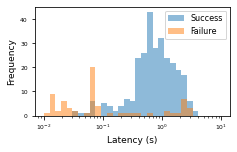

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

bins = np.logspace(-2, 1, 32)

# Get only the results
result_times = assess_result_transfer_overhead(target_run['path'], successful=True)
ax.hist(result_times, bins=bins, label='Success', alpha=0.5)

result_times = assess_result_transfer_overhead(target_run['path'], successful=False)
ax.hist(result_times, bins=bins, label='Failure', alpha=0.5)

ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Latency (s)')
ax.set_ylabel('Frequency')

Get the median task times

In [32]:
def get_simulation_times(path: Path) -> np.ndarray:
    """Get the time required for each simulation"""
    
    sim_tasks = pd.read_json(path / 'simulation-results.json', lines=True)
    return sim_tasks['time_running'].values

In [33]:
sim_runtime = get_simulation_times(target_run['path'])
print(f'Median simulation time: {np.median(sim_runtime):.2f}s')

Median simulation time: 2711.48s


## Assess Inference Overheads
We need to look at the node start up time and the time it takes to communicate requests/results.

In [34]:
log_data = load_log(target_run['path'])

In [35]:
def assess_startup_time(path: Path) -> np.ndarray:
    """Get the time it requires for the workers to startup"""
    
    # Load the data
    log_data = load_log(path)
    start_time = log_data['datetime'].iloc[0]
    log_data['time'] = log_data['datetime'] - start_time
    
    # Determine when nodes are allocated
    #node_registered = log_data[log_data.message.str.startswith('[MAIN] Adding manager')]
    
    # Determine when compute starts on a node
    inf_log = pd.read_json(path / 'inference-records.json', lines=True)
    inf_log['node_id'] = inf_log['task_info'].apply(lambda x: x['executor'])
    
    # Determine time times nodes are requested
    allocation = get_resource_allocation(path)
    allocation['n_requested'] = allocation['inference'].diff()
    requests = allocation[allocation['n_requested'] > 0]
    request_times = np.repeat(requests['time'].values, requests['n_requested'])
    
    # Determine when they are no longer needed
    finishes = allocation[allocation['n_requested'] < 0]
    
    # Loop over each round of inference requests
    start_times = []
    for batch_start, batch_end in zip([0] + finishes.time.tolist(), finishes['time']):
        # Get the requests that occurred during the batch
        batch_reqs = request_times[np.logical_and(request_times < batch_end, request_times > batch_start)]
        
        # Get the times node start compute after the first nodes are requested in this batch
        
        #batch_regs = node_registered.query(f'time < {batch_end} and time > {batch_reqs.min()}')
        batch_cmps = inf_log.query(f'time_compute_started < {batch_end + start_time} and time_compute_started > {batch_reqs.min() + start_time}').copy()
        batch_cmps.sort_values('time_compute_started', inplace=True)
        batch_cmps.drop_duplicates('node_id', keep='first', inplace=True)
        compute_starts = batch_cmps['time_compute_started'] - start_time
        
        # Add in the response times
        for s, e in zip(batch_reqs, compute_starts):
            start_times.append(e - s)
    
    # Get only the start times >0. 
    #  There is a problem in that Parsl will create more nodes than we request
    start_times = np.array([s for s in start_times if s > 0])
    return start_times
print(f'Median startup time: {np.median(assess_startup_time(target_run["path"])):.2f} s')

Median startup time: 101.46 s


In [36]:
result_trans = assess_result_transfer_overhead(target_run['path'], 'inference-records.json')
print(f'Result transfer times: Median {np.median(result_trans):.3f}s - Mean {np.mean(result_trans):.3f}s - Max {np.max(result_trans):.3f}s')

Result transfer times: Median 0.222s - Mean 0.262s - Max 4.787s


In [37]:
def get_execution_times(path: Path, warmed_only: bool = False) -> np.ndarray:
    """Get the execution times for the inference tasks
    
    Args:
        path: Path to result directory
        warmed_only: Whether to get only the warmed containers or not
    """
    
    # Get the start time
    log_data = load_log(path)
    start_time = log_data['datetime'].iloc[0]
    
    # Get the inference results
    inf_results = pd.read_json(path / 'inference-records.json', lines=True)
    inf_results['time_compute_started'] -= start_time
    inf_results['node_id'] = inf_results['task_info'].apply(lambda x: x['executor'])
    
    # Get the dividers for each batch of inference
    allocation = get_resource_allocation(path)
    allocation['n_requested'] = allocation['inference'].diff()
    
    batch_edges = [0] + allocation[allocation['n_requested'] < 0]['time'].values.tolist()
    
    # For each batch, separate "first" jobs per node from "warmed" jobs
    warmed_jobs = []
    first_jobs = []
    for s, e in zip(batch_edges, batch_edges[1:]):
        # Get the jobs during this batch
        jobs = inf_results.query(f'{s} < time_compute_started < {e}').copy()
        assert len(jobs) == 16 * 32
        
        # Label the first jobs
        jobs['is_first'] = False
        jobs.sort_values('time_compute_started', inplace=True)
        jobs.loc[jobs.drop_duplicates('node_id', keep='first').index, 'is_first'] = True
        
        # Append results
        warmed_jobs.extend(jobs.query('not is_first')['time_running'].values.tolist())
        first_jobs.extend(jobs.query('is_first')['time_running'].values.tolist())
    
    return np.array(warmed_jobs), np.array(first_jobs)

In [38]:
warmed_inf, first_inf = get_execution_times(target_run['path'])

In [39]:
print(f'Warmed inference times: Median {np.median(warmed_inf):.2f}s - Mean {np.mean(warmed_inf):.2f}s - Max {np.max(warmed_inf):.2f}s')
print(f'First inference times: Median {np.median(first_inf):.2f}s - Mean {np.mean(first_inf):.2f}s - Max {np.max(first_inf):.2f}s')

Warmed inference times: Median 79.72s - Mean 49.43s - Max 84.64s
First inference times: Median 99.41s - Mean 99.48s - Max 101.21s


## Assess Training Overheads
We need to look at the time to receive results

In [40]:
def get_training_times(path: Path) -> np.ndarray:
    """Get the time required for training"""
    
    results = pd.read_json(path / 'training-results.json', lines=True)
    return results['time_running'].values

In [41]:
train_times = get_training_times(target_run['path'])
print(f'Training times: Median {np.median(train_times):.2f}s - Mean {np.mean(train_times):.2f}s - Max {np.max(train_times):.2f}s')

Training times: Median 2966.43s - Mean 3263.85s - Max 8772.40s


In [42]:
result_trans = assess_result_transfer_overhead(target_run['path'], 'training-results.json')
print(f'Result transfer times: Median {np.median(result_trans):.2f}s - Mean {np.mean(result_trans):.2f}s - Max {np.max(result_trans):.2f}s')

Result transfer times: Median 5.69s - Mean 5.48s - Max 7.50s
